In [1]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import system.robot as robotSystem
import system.utils.transformation_matrix as Tf
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from alpha_reach import Params as alpha_params

In [2]:
alpha = robotSystem.RobotDynamics()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(
    project_root,
    'usage',
    'urdf','reach_alpha_5',
    'alpha_5_robot.urdf'
)
alpha.from_file(path_to_urdf)
root = "base_link"
tip = "alpha_standard_jaws_base_link"
kinematic_dict, K, P, L, D, C, g, B, qdd, joint_torque, sys_id_coeff, F_payload = alpha.build_model(root, tip, floating_base=True)
kinematic_dict = alpha.get_kinematic_dict()
c_parms, m_params, I_params, fv_coeff, fc_coeff, fs_coeff, v_s_coeff, vec_g, r_com_body, m_p, q, q_dot, q_dotdot, tau, base_pose, world_pose, tip_offset_pose = kinematic_dict['parameters']
joint_min = np.array([1.00, 0.01, 0.01, 0.01])
joint_max = np.array([5.50, 3.40, 3.40, 5.70])
base_T0 = [0.190, 0.000, -0.120, 3.142, 0.000, 0.000] # underarm 
base_T1 = [0.0, 0.000, 0.0, 0.0, 0.000, 0.000] # overarm
tipOffset_T = [0.0, 0.000, 0.0, 0.0, 0.000, 0.000] # no offset
n_joints = alpha.get_n_joints(root, tip)

In [3]:
R_f = ca.Function("R_f", [q, base_pose, world_pose, tip_offset_pose], [ kinematic_dict['R_symx'][-1]]) # rotation matrix
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose, tip_offset_pose], [kinematic_dict['qFks'][-1]]) # forward kinematics in quaternion form
body_J_eval = ca.Function("body_J_eval", [q, base_pose, world_pose, tip_offset_pose], [kinematic_dict['body_J'][-1]]) # body Jacobian
geo_J_eval = ca.Function("geo_J_eval", [q, base_pose, world_pose, tip_offset_pose], [kinematic_dict['geo_J'][-1]]) # geometric Jacobian
anlyt_J_eval = ca.Function("anlyt_J_eval", [q, base_pose, world_pose, tip_offset_pose], [kinematic_dict['anlyt_J'][-1]]) # analytical Jacobian

In [4]:
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose, tip_offset_pose], kinematic_dict['qFks'])
# c , cpp or matlab code generation for forward kinematics
fk_eval.save('fk_eval.casadi')
fk_eval.generate("fk_eval_.c")
os.system(f"gcc -fPIC -shared fk_eval_.c -o libFK.so")


fk_com_eval = ca.Function("fkcomeval", [q, ca.vertcat(*c_parms), r_com_body, base_pose, world_pose, tip_offset_pose], kinematic_dict['com_qFks'])
# c , cpp or matlab code generation for center of mass forward kinematics
fk_com_eval.generate("fk_com_eval.c")
os.system(f"gcc -fPIC -shared fk_com_eval.c -o libFKcom.so")


0

In [5]:
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose, tip_offset_pose], [kinematic_dict['Fks'][-1]])
def so3_log(R):
    tr = ca.trace(R)
    c  = (tr - 1) / 2
    c  = ca.fmin(1, ca.fmax(-1, c))
    theta = ca.acos(c)
    A = ca.if_else(theta < 1e-6, 1 + theta**2/6, theta/ca.sin(theta))
    return Tf.vee(0.5 * A * (R - R.T))  # 3x1


def verify_geometric_jacobian(
        q,           # joint‑angle vector    (iterable of scalars)
        q_dot,             # joint‑rate vector    (iterable of scalars)
        base_T,            # point of manipulator base attachment wrt to floating origin
        p_n,           # world pose
        tip_offset, #tip_offset
        *, 
        epsilon  = 1e-6,   # finite‑difference step
        frame    = "spatial",  # "spatial" | "body"
        verbose  = True,
):
    # make CasADi vectors
    q  = ca.vertcat(q)
    q_dot  = ca.vertcat(q_dot)
    p_n = ca.vertcat(p_n)

    # ------------------------------------------------------------------
    # Forward kinematics at   n ± ε q̇
    # ------------------------------------------------------------------
    pose_p = fk_eval(q + epsilon*q_dot, base_T, p_n, tip_offset)     # 6×1 (xyz+rp y)
    pose_m = fk_eval(q - epsilon*q_dot, base_T, p_n, tip_offset)
    p_p, p_m = pose_p[:3], pose_m[:3]               # positions

    # central‑difference linear velocity in spatial frame
    v_linear_fd = (p_p - p_m) / (2*epsilon)

    # central difference for angular velocity
    R_m = R_f(q - epsilon*q_dot, base_T, p_n, tip_offset)
    R_0 = R_f(q,                 base_T, p_n, tip_offset)
    R_p = R_f(q + epsilon*q_dot, base_T, p_n, tip_offset)

    # use proper SO(3) log
    R_rel = R_m.T @ R_p
    omega_body_fd   = so3_log(R_rel) / (2*epsilon)
    omega_spatial_fd = R_0 @ omega_body_fd

    # ------------------------------------------------------------------
    # Jacobian prediction
    # ------------------------------------------------------------------
    Jg = geo_J_eval(q, base_T, p_n, tip_offset)     # spatial Jacobian (6×n)
    Jb = body_J_eval(q, base_T, p_n, tip_offset)     # body    Jacobian (6×n)

    if frame.lower() == "spatial":
        twist_pred = Jg @ q_dot
        v_pred     = twist_pred[:3]
        w_pred     = twist_pred[3:]
        v_err      = float(ca.norm_2(v_linear_fd     - v_pred))
        w_err      = float(ca.norm_2(omega_spatial_fd - w_pred))

    elif frame.lower() == "body":
        twist_pred = Jb @ q_dot
        v_pred     = twist_pred[:3]
        w_pred     = twist_pred[3:]
        v_err      = float(ca.norm_2(v_linear_fd - v_pred))
        w_err      = float(ca.norm_2(omega_body_fd      - w_pred))

    else:
        raise ValueError("frame must be 'spatial' or 'body'")

    # ------------------------------------------------------------------
    # diagnostics
    # ------------------------------------------------------------------
    if verbose:
        print(f"Frame: {frame}")
        print("v_fd  :",   np.array(v_linear_fd.full().squeeze()))
        print("v_pred:",   np.array(v_pred.full().squeeze()))
        print("ω_fd  :",   np.array((omega_spatial_fd if frame=='spatial' else omega_body_fd).full().squeeze()))
        print("ω_pred:",   np.array(w_pred.full().squeeze()))
        print("‖Δv‖  :", v_err)
        print("‖Δω‖  :", w_err)

    return v_err, w_err


In [6]:
v_err, w_err = verify_geometric_jacobian(
    q      = [ca.pi, ca.pi, ca.pi, ca.pi],
    q_dot  = [0.5,0.5,0.7,0.5],
    base_T = base_T0,
    p_n    = [0.0, 1.0, 0, 0, 0, 0],
    tip_offset = tipOffset_T,
    frame  = "spatial"
)
assert v_err < 1e-6 and w_err < 1e-6, "Jacobian check failed"


Frame: spatial
v_fd  : [-4.61000265e-02 -1.00230935e-05  2.39999979e-02]
v_pred: [-4.61000265e-02 -1.00228984e-05  2.39999979e-02]
ω_fd  : [-1.85751287e-06 -1.99999984e-01 -8.14692673e-05]
ω_pred: [-1.85751286e-06 -1.99999983e-01 -8.14692798e-05]
‖Δv‖  : 1.9517481216364222e-10
‖Δω‖  : 1.1742711303412966e-10


<h1>Workspace Analysis</h1>

In [7]:
min_pos_fb, max_pos_fb, workspace_wrt_vehicle_base = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T0, floating_base=True, num_samples=25000)
min_pos_fx, max_pos_fx, workspace_wrt_arm_base = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T1, floating_base=False, num_samples=25000)
np.save("workspace.npy", workspace_wrt_vehicle_base)
workspace_wrt_vehicle_base = np.load("workspace.npy")

In [8]:
workspace_mask_wrt_vehicle_base = np.logical_and.reduce([
        workspace_wrt_vehicle_base[:, 0] > 0.25,
        workspace_wrt_vehicle_base[:, 1] > -0.03,
        workspace_wrt_vehicle_base[:, 1] < 0.03,
        workspace_wrt_vehicle_base[:, 2] < -0.15,
    ])

constrained_workspace_wrt_vehicle_base = workspace_wrt_vehicle_base[workspace_mask_wrt_vehicle_base]

workspace_mask_wrt_arm_base = np.logical_and.reduce([
        workspace_wrt_arm_base[:, 0] > 0.04,
        workspace_wrt_arm_base[:, 1] > -0.03,
        workspace_wrt_arm_base[:, 1] < 0.03,
        workspace_wrt_arm_base[:, 2] > 0.03,
    ])

constrained_workspace_wrt_arm_base = workspace_wrt_arm_base[workspace_mask_wrt_arm_base]

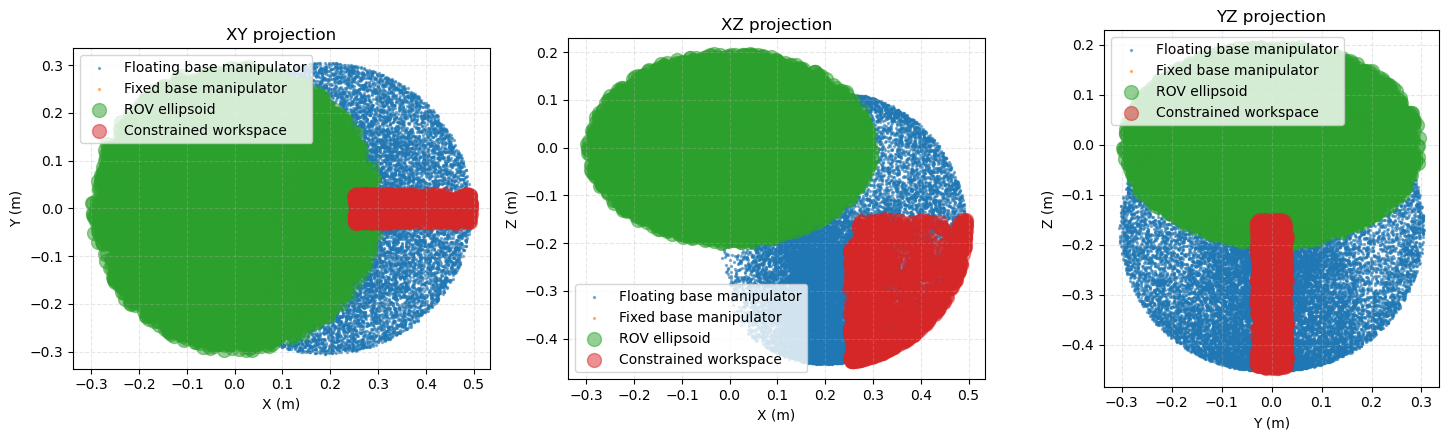

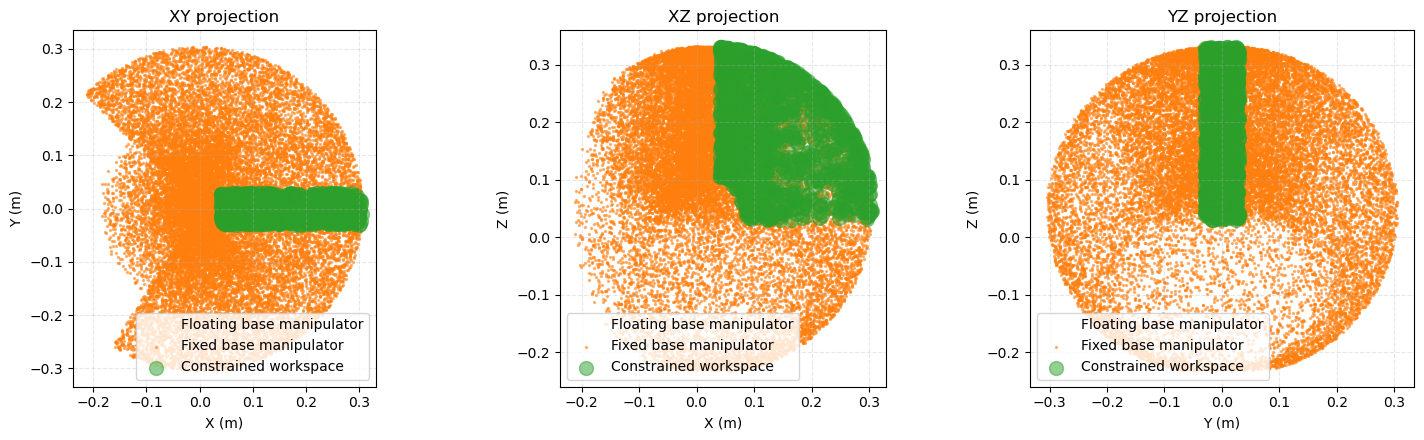

In [9]:
# -------------------- Sampling --------------------
def generate_rov_ellipsoid(a=0.5, b=0.3, c=0.2, num_points=10_000, center=(0,0,0), R=None, rng=None):
    """
    Uniformly sample points inside the ellipsoid (x/a)^2 + (y/b)^2 + (z/c)^2 <= 1.
    Rejection free using random directions + radius^(1/3).
    - center: optional 3D translation
    - R: optional 3x3 rotation matrix
    """
    rng = np.random.default_rng(rng)
    v = rng.normal(size=(num_points, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True).clip(min=1e-12)  # unit directions
    r = rng.random((num_points, 1)) ** (1/3)                        # radial distribution
    pts = r * v * np.array([a, b, c])
    if R is not None:
        pts = pts @ np.asarray(R).T
    return pts + np.asarray(center)

# -------------------- Utilities --------------------
def _limits_from_data(arrs, pad=0.05):
    """Get padded min/max per axis from a list of arrays shaped (N, D), D=2 or 3."""
    arrs = [np.asarray(a) for a in arrs if a is not None and len(a) > 0]
    data = np.vstack(arrs)
    mins, maxs = data.min(axis=0), data.max(axis=0)
    span = np.maximum(maxs - mins, 1e-9)
    return mins - pad * span, maxs + pad * span


def plot_workspace_2d(
    positions_fb,
    positions_fx,
    extra_pts=None,
    extra_labels=None,
    s_fb=2,
    s_fx=2,
    s_extra=2,
    lims=None,
    use_hexbin=False,
    gridsize=80,
):
    """
    XY, XZ, YZ projections in a single row with equal aspect and shared limits per view.
    extra_pts can be:
      - None
      - a single (N,3) array
      - a list of (Ni,3) arrays
    """
    Pfb = np.asarray(positions_fb)
    Pfx = np.asarray(positions_fx)

    # Normalize extra_pts to a list of arrays
    if extra_pts is None:
        Pex_list = []
    elif isinstance(extra_pts, (list, tuple)):
        Pex_list = [np.asarray(pex_i) for pex_i in extra_pts]
    else:
        Pex_list = [np.asarray(extra_pts)]

    views = [('X','Y',(0,1)), ('X','Z',(0,2)), ('Y','Z',(1,2))]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

    for ax, (ax0, ax1, (i, j)) in zip(axes, views):
        # limits
        if lims is None:
            all_slices = [
                Pfb[:, [i, j]],
                Pfx[:, [i, j]] if Pfx.size > 0 else None,
            ] + [
                pex[:, [i, j]] for pex in Pex_list if pex.size > 0
            ]
            mins2, maxs2 = _limits_from_data(all_slices)
        else:
            mins2 = np.array(lims[0])[ [i, j] ]
            maxs2 = np.array(lims[1])[ [i, j] ]

        if use_hexbin:
            ax.hexbin(Pfb[:, i], Pfb[:, j], gridsize=gridsize, mincnt=1, alpha=0.5)
            if Pfx.size > 0:
                ax.hexbin(Pfx[:, i], Pfx[:, j], gridsize=gridsize, mincnt=1, alpha=0.5)
            for pex in Pex_list:
                ax.hexbin(pex[:, i], pex[:, j], gridsize=gridsize, mincnt=1, alpha=0.3)
        else:
            ax.scatter(Pfb[:, i], Pfb[:, j], s=s_fb, alpha=0.5, label='Floating base manipulator')
            ax.scatter(Pfx[:, i], Pfx[:, j], s=s_fx, alpha=0.5, label='Fixed base manipulator')

            for idx, pex in enumerate(Pex_list):
                if extra_labels is not None and idx < len(extra_labels):
                    label = extra_labels[idx]
                else:
                    label = f'Extra {idx+1}'
                ax.scatter(pex[:, i], pex[:, j], s=s_extra, alpha=0.5, label=label)

        ax.set_xlabel(f'{ax0} (m)')
        ax.set_ylabel(f'{ax1} (m)')
        ax.set_xlim(mins2[0], maxs2[0])
        ax.set_ylim(mins2[1], maxs2[1])
        ax.set_aspect('equal', 'box')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_title(f'{ax0}{ax1} projection')

        if not use_hexbin:
            ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


floating_base_ellipsoid_clpts = generate_rov_ellipsoid(a=0.3, b=0.3, c=0.2, num_points=10000)
# Plot
empty = np.empty((0, 3))
plot_workspace_2d(
    workspace_wrt_vehicle_base,
    empty,
    extra_pts=[floating_base_ellipsoid_clpts, constrained_workspace_wrt_vehicle_base],
    extra_labels=['ROV ellipsoid', 'Constrained workspace'],
    s_extra=100,
)


# Plot
plot_workspace_2d(
    empty,
    workspace_wrt_arm_base,
    extra_pts=[constrained_workspace_wrt_arm_base],
    extra_labels=['Constrained workspace'],
    s_fb=0,                             # no points
    s_fx=2,
    s_extra=100,
)

In [10]:
# Precompute convex hull from your workspace points (positions_fb: (N x 3) array)
workspace_hull = ConvexHull(workspace_wrt_vehicle_base)
floating_base_hull = ConvexHull(floating_base_ellipsoid_clpts)

def is_endeffector_point_workspace_valid(point):
    """
    Returns True if 'point' is in the workspace hull but *not* in the vehicle hull.
    Equivalently, we want:  point ∈ (Workspace Vehicle) = Workspace ∩ (Vehicle)^c
    hull.equations: (F, d+1), rows are [normal, offset]
    """
    # np.all(points @ A.T + b <= tol, axis=1)
    inside_workspace = np.all(
        np.dot(workspace_hull.equations[:, :-1], point) + workspace_hull.equations[:, -1] <= 0
    )
    inside_vehicle = np.all(
        np.dot(floating_base_hull.equations[:, :-1], point) + floating_base_hull.equations[:, -1] <= 0
    )
    # accept the point if it is inside the workspace and *not* inside the vehicle hull.
    return inside_workspace and not inside_vehicle

In [11]:
task_point = np.array([0.31396762,  0.00519786, -0.21436635])  # Example target position

if is_endeffector_point_workspace_valid(task_point):
    print("Task is within the workspace.")
else:
    print("Task is out-of-workspace.")

Task is within the workspace.


In [12]:
def sample_valid_workspace_points(k, valid_points):
    """
    Randomly sample k points from the prefiltered valid workspace set.
    """
    if len(valid_points) == 0:
        raise ValueError("No valid workspace points available.")
    idx = np.random.choice(len(valid_points), size=k, replace=len(valid_points) < k)
    return valid_points[idx]

In [13]:
q012_fun_underarm, q012, p_base = alpha_params.build_analytic_underarm_ik_casadi()
q012_fun_underarm.save("ik_eval.casadi")
q012_fun_overarm, q012, p_base = alpha_params.build_analytic_overarm_ik_casadi()

# joint workspace
samples = sample_valid_workspace_points(80000, workspace_wrt_arm_base)
N = samples.shape[0]
fk_eval_vec = fk_eval.map(N)

# vectorized IK evaluation for workspace points
F_q012_underarm_fun = q012_fun_underarm.map(N)
joint_workspace_underarm_samples = F_q012_underarm_fun(samples.T).T
task_underarm_samples = fk_eval_vec(joint_workspace_underarm_samples.T, [0,0,0,0,0,0], [0,0,0,0,0,0], tipOffset_T)

F_q012_overarm_fun = q012_fun_overarm.map(N)
joint_workspace_overarm_samples = F_q012_overarm_fun(samples.T).T
task_overarm_samples = fk_eval_vec(joint_workspace_overarm_samples.T, [0,0,0,0,0,0], [0,0,0,0,0,0], tipOffset_T)

# constrained joint workspace
constrained_samples = sample_valid_workspace_points(80000, constrained_workspace_wrt_arm_base)
constrained_N = constrained_samples.shape[0]

# vectorized IK evaluation for constrained workspace points
constrained_F_q012_underarm_fun = q012_fun_underarm.map(constrained_N)
constrained_joint_workspace_underarm_samples = constrained_F_q012_underarm_fun(constrained_samples.T).T
constrained_task_underarm_samples = fk_eval_vec(constrained_joint_workspace_underarm_samples.T, [0,0,0,0,0,0], [0,0,0,0,0,0], tipOffset_T)

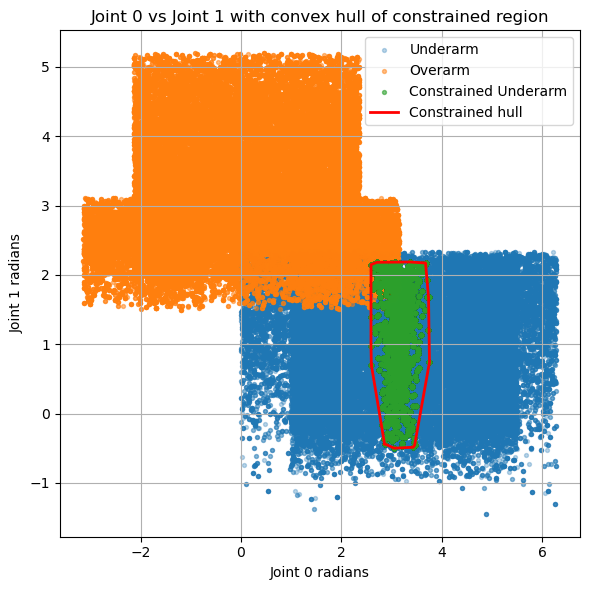

Correlation matrix Underarm
[[ 1.         -0.00680786]
 [-0.00680786  1.        ]]
Correlation matrix Overarm
[[1.         0.01117806]
 [0.01117806 1.        ]]


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# convert rad to radians
radians_under = joint_workspace_underarm_samples.full()
radians_over  = joint_workspace_overarm_samples.full()
constrained_radians_under = constrained_joint_workspace_underarm_samples.full()

# extract joint 0 and joint 1 columns
u0, u1 = radians_under[:, 0], radians_under[:, 1]
o0, o1 = radians_over[:, 0], radians_over[:, 1]
constrained_u0  = constrained_radians_under[:, 0]
constrained_u1  = constrained_radians_under[:, 1]

# stack constrained points for hull
constrained_points = np.column_stack((constrained_u0, constrained_u1))

# compute convex hull of constrained region
hull = ConvexHull(constrained_points)

plt.figure(figsize=(6, 6))

# scatter points
plt.scatter(u0, u1, s=8, alpha=0.3, label="Underarm")
plt.scatter(o0, o1, s=8, alpha=0.5, label='Overarm')
plt.scatter(constrained_u0, constrained_u1, s=8, alpha=0.6, label="Constrained Underarm")
# plot convex hull boundary
hull_vertices = hull.vertices
plt.plot(
    constrained_points[hull_vertices, 0],
    constrained_points[hull_vertices, 1],
    "r-",
    linewidth=2,
    label="Constrained hull",
)

# close the polygon visually
plt.plot(
    [constrained_points[hull_vertices[-1], 0], constrained_points[hull_vertices[0], 0]],
    [constrained_points[hull_vertices[-1], 1], constrained_points[hull_vertices[0], 1]],
    "r-",
    linewidth=2,
)

plt.xlabel("Joint 0 radians")
plt.ylabel("Joint 1 radians")
plt.title("Joint 0 vs Joint 1 with convex hull of constrained region")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Correlation matrix Underarm")
print(np.corrcoef(u0, u1))

print("Correlation matrix Overarm")
print(np.corrcoef(o0, o1))


In [15]:
# Inside the polygon means  A @ [q0, q1] + b <= 0
A_hull = hull.equations[:, :2]   # shape (m, 2)
b_hull = hull.equations[:, 2]    # shape (m,)

In [23]:
fb_IK_solver = alpha.build_floating_base_ik_fun(floating_base=True, use_joint_polytope_constraint = True, polytope_shape = A_hull.shape, polytope_joint_indices=[0,1])
target = [40,30,10, .5,0,0]
q_x_sol = fb_IK_solver(target, alpha_params.base_T0_new, alpha_params.tipOffset, alpha_params.joint_min, alpha_params.joint_max, A_hull, b_hull)
print(q_x_sol)
f_x_sol = fk_eval(q_x_sol[0:4], alpha_params.base_T0_new ,q_x_sol[4:10], alpha_params.tipOffset)
print(f_x_sol)
print(target)

[2.90466, 0.737739, 2.85562, 0.459021, 39.9409, 30.0014, 9.532, 1.3915, -1.29873, 0.11763]
[40, 30, 10, 0.5, 4.4422e-09, -9.30292e-10]
[40, 30, 10, 0.5, 0, 0]


In [24]:
# task_pose quat_wxyz geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=0.23597975075244904, y=-0.20338258147239685, z=-0.36039111018180847),
#                                             orientation=geometry_msgs.msg.Quaternion(x=0.9884957075119019, y=0.023335274308919907, z=-0.14941395819187164, 
#                                                                                      w=0.002687751781195402))

In [26]:
# task_pose rpy (array([ 0.23597975, -0.20338258, -0.36039111]), array([-3.1398555 ,  0.29999511,  0.04746748]))


In [27]:
target = [ 0.23597975, -0.20338258, -0.36039111, -3.1398555 ,  0.29999511,  0.04746748]
q_x_sol = fb_IK_solver(target, alpha_params.base_T0_new, alpha_params.tipOffset, alpha_params.joint_min, alpha_params.joint_max, A_hull, b_hull)
print(q_x_sol)

[2.83401, 1.44833, 0.0782767, 1.31231, 0.0434189, -0.34467, -0.55913, -1.34093, 4.60003, 2.05918]


In [28]:
f_x_sol = fk_eval(q_x_sol[0:4], alpha_params.base_T0_new ,q_x_sol[4:10], alpha_params.tipOffset)
print(f_x_sol)

[0.23598, -0.203383, -0.360391, -3.13986, 0.299995, 0.0474675]


In [ ]:

Body IK  solution [3.101442159520577, 1.1002125339522542, 0.03985660212047758, 1.0181923524540604, 0.09636128250177659, 
                   -0.46822133963690254, -0.47977052264228015, -3.7169151055362972, -8.261354485053571, -1.610720179408578]


In [29]:
q_x_sol = [3.101442159520577, 1.1002125339522542, 0.03985660212047758, 1.0181923524540604, 0.09636128250177659, 
                   -0.46822133963690254, -0.47977052264228015, -3.7169151055362972, -8.261354485053571, -1.610720179408578]
f_x_sol = fk_eval(q_x_sol[0:4], alpha_params.base_T0_new ,q_x_sol[4:10], alpha_params.tipOffset)
print(f_x_sol)

[0.23598, -0.203383, -0.360391, -3.13986, 0.299995, 0.0474675]


In [17]:
A_hull

array([[-0.16264344, -0.98668491],
       [-0.99205742,  0.12578582],
       [-0.99048456,  0.13762388],
       [-0.99998651, -0.00519486],
       [-0.98729833, -0.15887731],
       [ 0.44703829, -0.89451482],
       [ 0.54938951, -0.83556637],
       [ 0.78247019,  0.62268805],
       [ 0.48619467,  0.87385053],
       [ 0.03600116,  0.99935175],
       [ 0.99950171, -0.03156462],
       [ 0.99929629, -0.03750893],
       [ 0.97332742, -0.22942042],
       [ 0.98536598, -0.17045201],
       [-0.15512924,  0.98789418],
       [-0.05032086,  0.9987331 ]])

In [18]:
b_hull

array([-0.06606122,  2.30546777,  2.27882721,  2.54801163,  2.68511285,
       -1.86907234, -2.16869514, -4.22341847, -3.64391402, -2.29628365,
       -3.68524159, -3.6785779 , -3.41384489, -3.50756616, -1.72238603,
       -2.04433397])

In [19]:
fb_IK_solver.save('whole_body_ik.casadi')

In [20]:
ab_IK_solver = alpha.build_floating_base_ik_fun(floating_base=False, use_joint_polytope_constraint = True, polytope_shape = A_hull.shape, polytope_joint_indices=[0,1])
xyz_target = [0.1,0.05,0.1]
q_x_sol = ab_IK_solver(xyz_target, tipOffset_T, alpha_params.joint_min, alpha_params.joint_max, A_hull, b_hull)
# ab_IK_solver.save('ik_eval.casadi')
print(q_x_sol)
f_x_sol = fk_eval(q_x_sol[0:4],[0,0,0,0,0,0] ,[0,0,0,0,0,0], tipOffset_T)
print(f_x_sol)
print(xyz_target)

[3.60524, 0.776768, 0.335776, 0.01]
[0.1, 0.05, 0.1, 0.208029, -0.391715, 2.58945]
[0.1, 0.05, 0.1]


In [18]:
ab_IK_solver = alpha.build_floating_base_ik_fun(floating_base=False, use_joint_polytope_constraint = False)
q_x_sol = ab_IK_solver([-0.0439852, -0.0685028, 0.0346436], tipOffset_T, alpha_params.joint_min, alpha_params.joint_max)
print(q_x_sol)
f_x_sol = fk_eval(q_x_sol[0:4],[0,0,0,0,0,0] ,[0,0,0,0,0,0],tipOffset_T)
print(f_x_sol)

[1, 0.01, 0.01, 0.01]
[-0.0440082, -0.0685386, 0.0348573, -1.43372e-08, -2.23288e-08, -0.0572053]
